# 분석 

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

In [129]:
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [100]:
%%time
#19~21년 데이터 불러오기
df1 = pd.read_csv("/Users/baegnamjin/Desktop/Dataset/나드리콜/추가 나드리콜 데이터/1. 20년~23년 데이터/nadri2021.csv")
df2 = pd.read_csv("/Users/baegnamjin/Desktop/Dataset/나드리콜/추가 나드리콜 데이터/1. 20년~23년 데이터/nadri2022.csv")
df3 = pd.read_csv("/Users/baegnamjin/Desktop/Dataset/나드리콜/추가 나드리콜 데이터/1. 20년~23년 데이터/nadri2023.csv")

CPU times: user 8.4 s, sys: 1.88 s, total: 10.3 s
Wall time: 12 s


In [101]:
df = pd.concat([df1,df2,df3])
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Preprocessing

데이터에 잡음(noise)가 많아 전처리 과정 필요

In [102]:
# 시간 변수 datetime으로 변환
df['접수시간'] = pd.to_datetime(df['접수시간'])
df['승차시간'] = pd.to_datetime(df['승차시간'])
df['하차시간'] = pd.to_datetime(df['하차시간'])

In [103]:
# 하차 시간이 승차 시간보다 빠른 경우 삭제 (634rows)
df.drop(df.iloc[np.where(df['하차시간'] < df['승차시간'])].index, axis=0, inplace=True)

In [104]:
# 이용시간과 배차시간을 초(s)->분(m)으로 변환
df['이용시간(분)'] = round((df['하차시간'] - df['승차시간']).dt.total_seconds()/60, 0)
df['배차시간(분)'] = round(df['배차시간(초)']/60,0)
df.drop('배차시간(초)', axis=1, inplace=True)

In [105]:
# 이용 시간 0분 삭제
df = df[df['이용시간(분)'] != 0]

In [106]:
# 접수보다 먼저 승차한 경우 삭제
df = df[df['접수시간'] <= df['승차시간']]

# EDA

## 배차시간
고객이 접수하고 승차까지 걸린 시간

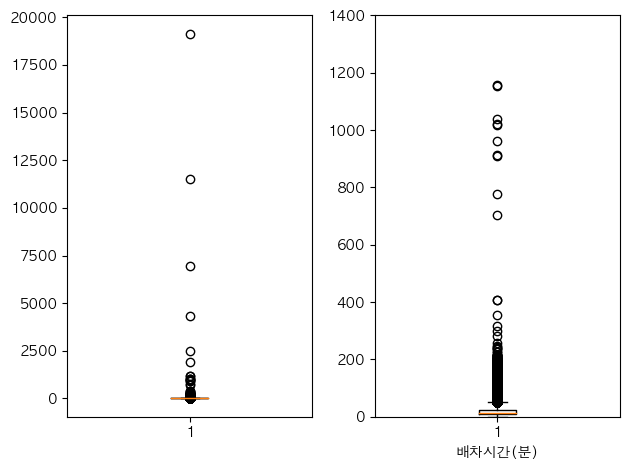

In [43]:
plt.subplot(1,2,1)
plt.boxplot(df['배차시간(분)']);

plt.subplot(1,2,2)
plt.boxplot(df['배차시간(분)']);
plt.xlabel("배차시간(분)")
plt.ylim(0,1400);
plt.tight_layout()

In [97]:
# 15분 이상 걸리는 비율
print(f"15분 이상 걸리는 비율 {sum(df['배차시간(분)'] > 15) / len(df['배차시간(분)']) * 100:.2f} %")

15분 이상 걸리는 비율 43.04 %


**Insight**

- 고객이 탑승하는 시간이 15분 이상이 약 50%며, 이상치가 많음.

## 이용시간

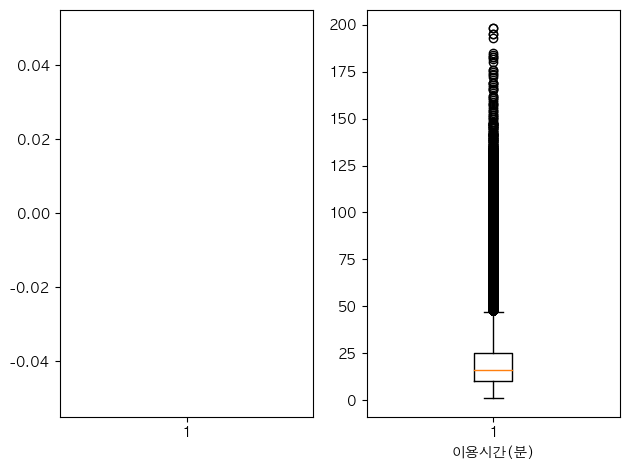

In [107]:
plt.subplot(1,2,1)
plt.boxplot(df['이용시간(분)']);

# 200분 이상 이용하는 경우는 많지 않기 때문에 삭제
df = df[df['이용시간(분)']  < 200]

plt.subplot(1,2,2)
plt.boxplot(df['이용시간(분)'])
plt.xlabel("이용시간(분)")
plt.tight_layout()

**Insight** 

- 이상치 존재

In [109]:
# 데이터 필터링: '배차시간(분)'이 500 미만인 데이터만 선택
df = df[df['배차시간(분)'] < 2500]

## 질환분류

In [110]:
import re

def normalize_string(s):
    if pd.isna(s):
        return 'Unknown'  # NaN 값 처리
    s = s.strip()  # 양쪽 공백 제거
    s = re.sub(r'\s+', ' ', s)  # 중간의 다중 공백을 단일 공백으로 변경
    return s

df['질환분류'] = df['질환분류'].apply(normalize_string)

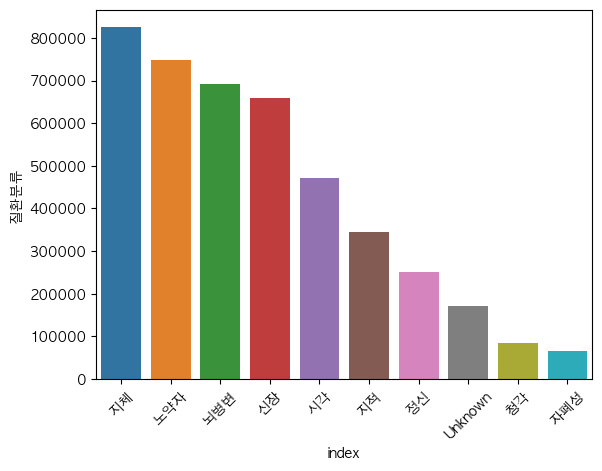

In [17]:
sns.barplot(data=df['질환분류'].value_counts()[:10].reset_index(), x='index', y='질환분류')
plt.xticks(rotation=45);

**Insight**

- 지체장애인이 가장 많았음.

## 목적지

<AxesSubplot: xlabel='배차시간(분)', ylabel='목적지분류'>

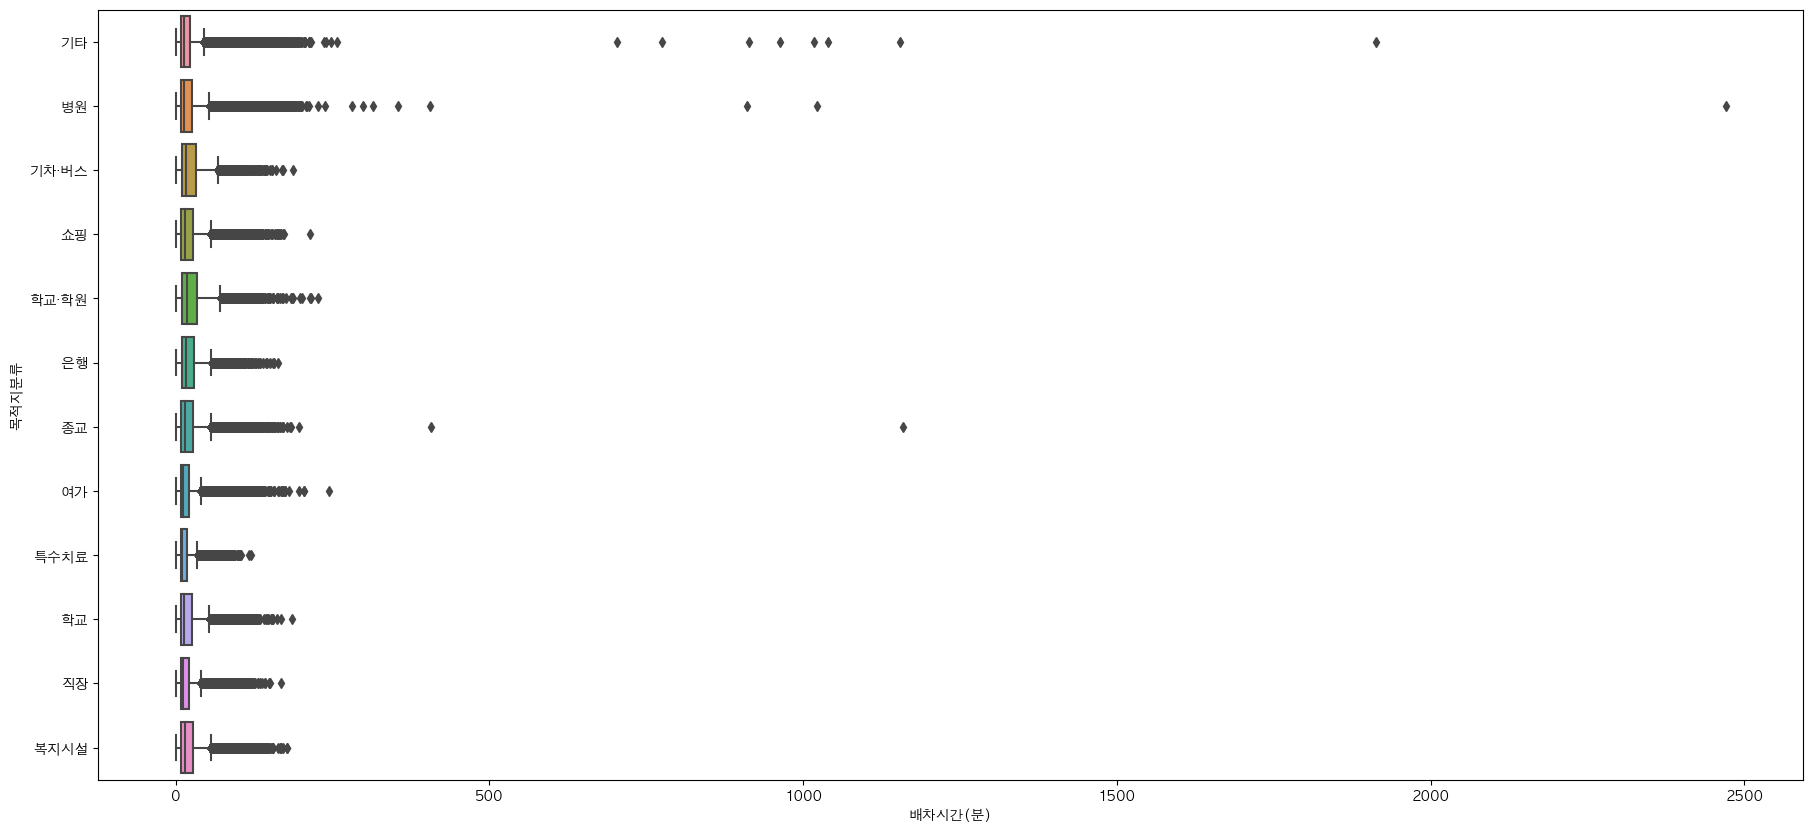

In [256]:
plt.figure(figsize=(22,10))
sns.boxplot(data=df, y='목적지분류',x='배차시간(분)')

**Insight**

- 어디를 목적지로 두든 배차시간(분)의 중앙값은 차이가 없어보임.

## 휄체어 유무 2

In [15]:
pivot_table = pd.pivot_table(df, index='휠체어유무', columns='배차 차량종류', aggfunc='size')
pivot_table

배차 차량종류,개인택시,특장차량
휠체어유무,,
무,3033921,651299
유,162969,555087


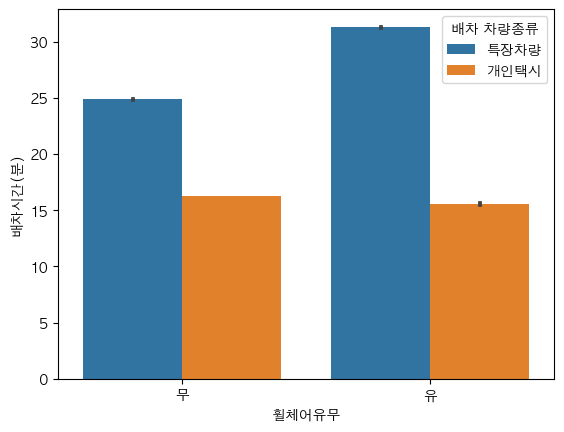

In [261]:
sns.barplot(x=df['휠체어유무'], y=df['배차시간(분)'], hue=df['배차 차량종류']);

- 휠체어를 타지 않는데 특장차량을 탄다.
- 휠체어 사용자들은 특장대기시간이 더욱 길다. 
    - 이는 휠체어 사용자들을 차량에 태우는 시간을 포함한 것(실제로 5분 정도 걸린다고 함)
    - 즉, 휠체어 유무에 따른 배차시간은 시각적으로 차이가 없음.

## 시간변수 추가

In [85]:
def time_transform(data):
    data['년도'] = data['접수시간'].dt.year
    data['월'] = data['접수시간'].dt.month
    data['일'] = data['접수시간'].dt.day
    data['일중주'] = data['접수시간'].dt.dayofweek
    data['HOUR'] = data['접수시간'].dt.hour

    return data

df = time_transform(df)

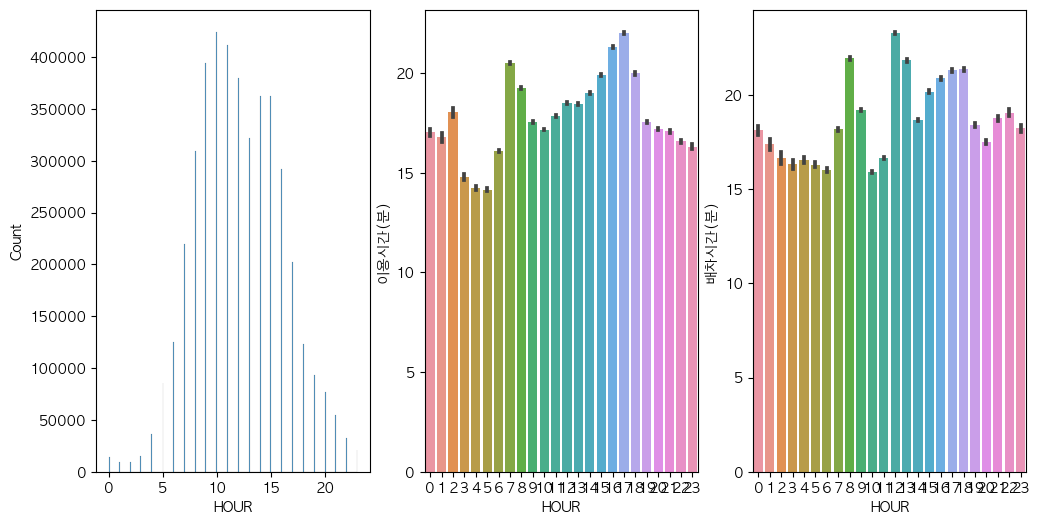

In [263]:
#어느 시간에 접수시간이 많은가?
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
sns.histplot(df['HOUR'])

#어느 시간에 이용시간이 가장 많은가?
plt.subplot(1,3,2)
sns.barplot(y=df['이용시간(분)'],x=df['HOUR']);

#어느 시간에 배차시간이 가장 많은가?
plt.subplot(1,3,3)
sns.barplot(y=df['배차시간(분)'],x=df['HOUR']);

<AxesSubplot: xlabel='일중주', ylabel='배차시간(분)'>

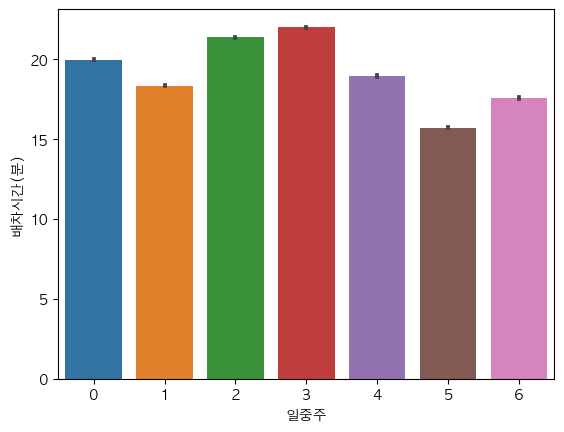

In [264]:
# 0:월요일 ~ 6:일요일
sns.barplot(x=df['일중주'],y=df['배차시간(분)'])

**Insight**

- 08~11시에 접수가 가장 많으며, 17시 이후로는 접수가 적음
- 출퇴근 하는 시간에 이용시간이 가장 많음
- 새벽 1시~오전 7시까지 배차시간이 매우 김
- 오후 7시부터 06시까지는 배차시간이 짧음
- **적절한 교대 시간은 오후 20시와 오전 6시로 판단**

In [111]:
# NaN 값을 'Unknown'으로 대체
df['출발지 행정동'] = df['출발지 행정동'].fillna('Unknown')

# 이후에 '동'으로 끝나는 행정동 이름만 필터링
df = df[df['출발지 행정동'].str.endswith(('동','읍','면'))]

#Normailzation
df['출발지 행정동'] = df['출발지 행정동'].apply(normalize_string)

# Plotly를 활용한 지도 시각화

In [112]:
import plotly.express as px
import json
import os

In [113]:
# 대구광역시 geojson 파일을 찾아서 다운
geometry_dg = json.load(open("./hangjeongdong_대구광역시.geojson", encoding='utf-8'))

In [114]:
# '대구광역시 ~구 ~동'에서 '~동'만 추출
for feature in geometry_dg['features']:
    adm_nm = feature['properties']['adm_nm']
    dong_name = adm_nm.split()[-1]  
    feature['properties']['adm_nm'] = dong_name

In [115]:
# jeojson과 변수명이 같아야 함
df.rename(columns={"출발지 행정동":"adm_nm"}, inplace=True)

In [121]:
# 행정동별 평균 배차시간 그룹핑
# groupby_df = df.groupby(['adm_nm'])['배차시간(분)'].mean().reset_index()
groupby_df = df.groupby(['adm_nm']).size().reset_index()
groupby_df.columns = ['출발지 행정동','접수건수']

In [126]:
# fig = px.choropleth(groupby_df, geojson=geometry_dg, locations='출발지 행정동', color='접수건수',
#                    color_continuous_scale='Blues', featureidkey='properties.adm_nm')

# fig.update_geos(fitbounds='locations', visible=False)
# fig.update_layout(title="어떤 동에서 가장 많은 배차시간을 나타내는가?", title_font_size=20)

In [132]:
# # 만약, 시간대로 보고싶다면?
# # hour_groupby = df.groupby(['HOUR','adm_nm']).agg({'배차시간(분)':'mean'}).reset_index()
# # hour_groupby['배차시간(분)_log'] = np.log1p(hour_groupby['배차시간(분)'])

# for i in range(24):
#     fig = px.choropleth(hour_groupby[hour_groupby['HOUR'] == i], 
#                         geojson=geometry_dg, 
#                         locations='adm_nm', 
#                         color='배차시간(분)_log',
#                         color_continuous_scale='Blues', 
#                         featureidkey='properties.adm_nm') #properties는 jeojson에서 adm_nm을 포함하는 key

#     fig.update_geos(fitbounds='locations', visible=False)
#     fig.update_layout(title=f"{i}시 대구광역시 행정동별 배차시간", title_font_size=20)

#     # 각 시간대별로 별도의 HTML 파일로 저장
#     fig.write_image(f"./Image/대구광역시_행정동별_배차시간_{i}시.png")

In [127]:

# import dash
# import dash_core_components as dcc
# import dash_html_components as html
# from dash.dependencies import Input, Output
# import plotly.express as px

# # 시간대별 그룹핑
# hour_groupby_2022 = df.groupby(['HOUR','adm_nm']).agg({'배차시간(분)':'mean'}).reset_index()

# app = dash.Dash(__name__)

# hour_groupby_2022['배차시간(분)_log'] = np.log1p(hour_groupby_2022['배차시간(분)'])

# # 초기 맵 설정 (예시: 0시에 대한 맵)
# initial_map = px.choropleth(hour_groupby_2022[hour_groupby_2022['HOUR'] == 0], 
#                             geojson=geometry_dg, 
#                             locations='adm_nm', 
#                             color='배차시간(분)_log',
#                             color_continuous_scale='Reds', 
#                             featureidkey='properties.adm_nm')

# app.layout = html.Div([
#     # 슬라이더를 통한 시간대 선택
#     dcc.Slider(
#         id='hour-slider',
#         min=0,
#         max=23,
#         step=1,
#         value=0,  # 초기값 설정
#         marks={i: f'{i}시' for i in range(24)}
#     ),
#     # Choropleth 맵을 표시할 영역
#     dcc.Graph(
#         id='choropleth-map',
#         figure=initial_map
#     )
# ])

# @app.callback(
#     Output('choropleth-map', 'figure'),
#     [Input('hour-slider', 'value')]
# )
# def update_map(selected_hour):
#     # 선택된 시간대에 따라 맵 업데이트
#     fig = px.choropleth(hour_groupby_2022[hour_groupby_2022['HOUR'] == selected_hour], 
#                         geojson=geometry_dg, 
#                         locations='adm_nm', 
#                         color='배차시간(분)_log',
#                         color_continuous_scale='Reds', 
#                         featureidkey='properties.adm_nm')
#     fig.update_geos(fitbounds='locations', visible=False)
#     return fig

# if __name__ == '__main__':
#     app.run_server(debug=True)

- 2021~23년
    - 특히 하빈면은 주간에 배차시간이 길었으며, 야간에는 완화됨
    - **08~20시 즈음에는 도심지역에 수요가 많고 콜이 대부분 잡히기 때문에 외곽 지역은 배차 시간은 길게 됨.**

# 결론

**외곽 지역의 배차 시간을 줄여야 한다고 판단함**
정기적인 운행 시스템을 추가적으로 서비스 제공한다. 구체적으로 행정동별, 시간대별 요청 인원을 예측하는 AI 모델을 개발하고 와곽 지역 맞춤형 최적의 운행 시간표를 구축한다. 이는 평균 배차 시간을 줄일 수 있는 기회가 되며 외곽 지역의 고객들에게 만족감을 줄 수 있을 것이다.

# Modeling

외곽 지역의 접수건수를 예측하는 모델을 구축하자.

In [92]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [93]:
# '접수시간'을 datetime 객체로 변환하고, 시간별로 그룹화하여 수요 카운트
df['접수시간'] = pd.to_datetime(df['접수시간'])
df['시간'] = df['접수시간'].dt.hour

hourly_demand = df.groupby(['일중주','월','HOUR','adm_nm']).size().reset_index()
hourly_demand.columns = ['일중주','월','시간','행정동','접수건수']

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
hourly_demand['행정동'] = le.fit_transform(hourly_demand['행정동'])

# '월', '일', '일중주', '시간', '행정동'을 특성으로, '접수건수'를 타겟으로 사용
features = ['일중주', '월', '시간', '행정동']
target = '접수건수'

In [94]:
X = hourly_demand[features]
y = hourly_demand[target]

In [95]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
r2_scores = []

for num, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = XGBRegressor(random_state=42, n_estimators=500)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, pred, squared=False)
    mse_scores.append(mse)
    
    r2 = r2_score(y_test, pred)
    r2_scores.append(r2)

    print(f"Fold {num+1}")
    print(f"MSE : {mse}")
    print(f"R2 : {r2}")

print()
print(f"Mean MSE : {np.mean(mse_scores):.2f}")
print(f"Mean R2 : {np.mean(r2_scores):.2f}")

Fold 1
MSE : 5.135537000533603
R2 : 0.9208997578534874
Fold 2
MSE : 5.163361867915201
R2 : 0.921141421565145
Fold 3
MSE : 5.10493706417607
R2 : 0.9213064287023909
Fold 4
MSE : 5.115992500288466
R2 : 0.9225053232101252
Fold 5
MSE : 5.096125458615711
R2 : 0.9203207060805922

Mean MSE : 5.12
Mean R2 : 0.92


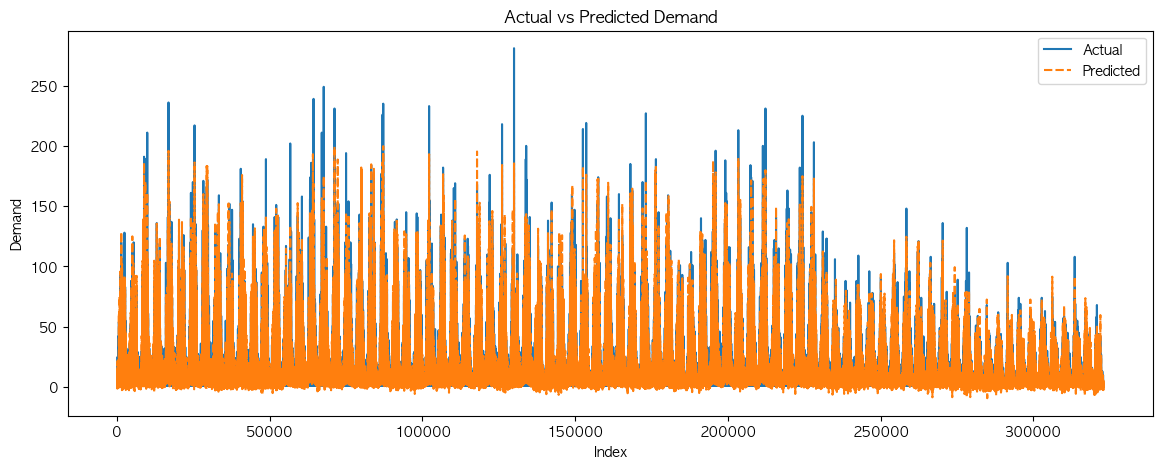

In [97]:
# 행정동별 수요 예측 결과 집계
hourly_demand_pred = X_test.copy()
hourly_demand_pred['Actual'] = y_test
hourly_demand_pred['Predicted'] = pred
hourly_demand_grouped = hourly_demand_pred.groupby(['행정동', '시간']).mean()

# 실제 값과 예측 값을 DataFrame으로 변환
results = pd.DataFrame({'Actual': y_test, 'Predicted': pred})

# 시각화
plt.figure(figsize=(14, 5))
sns.lineplot(data=results)
plt.title('Actual vs Predicted Demand')
plt.xlabel('Index')
plt.ylabel('Demand')
plt.show()


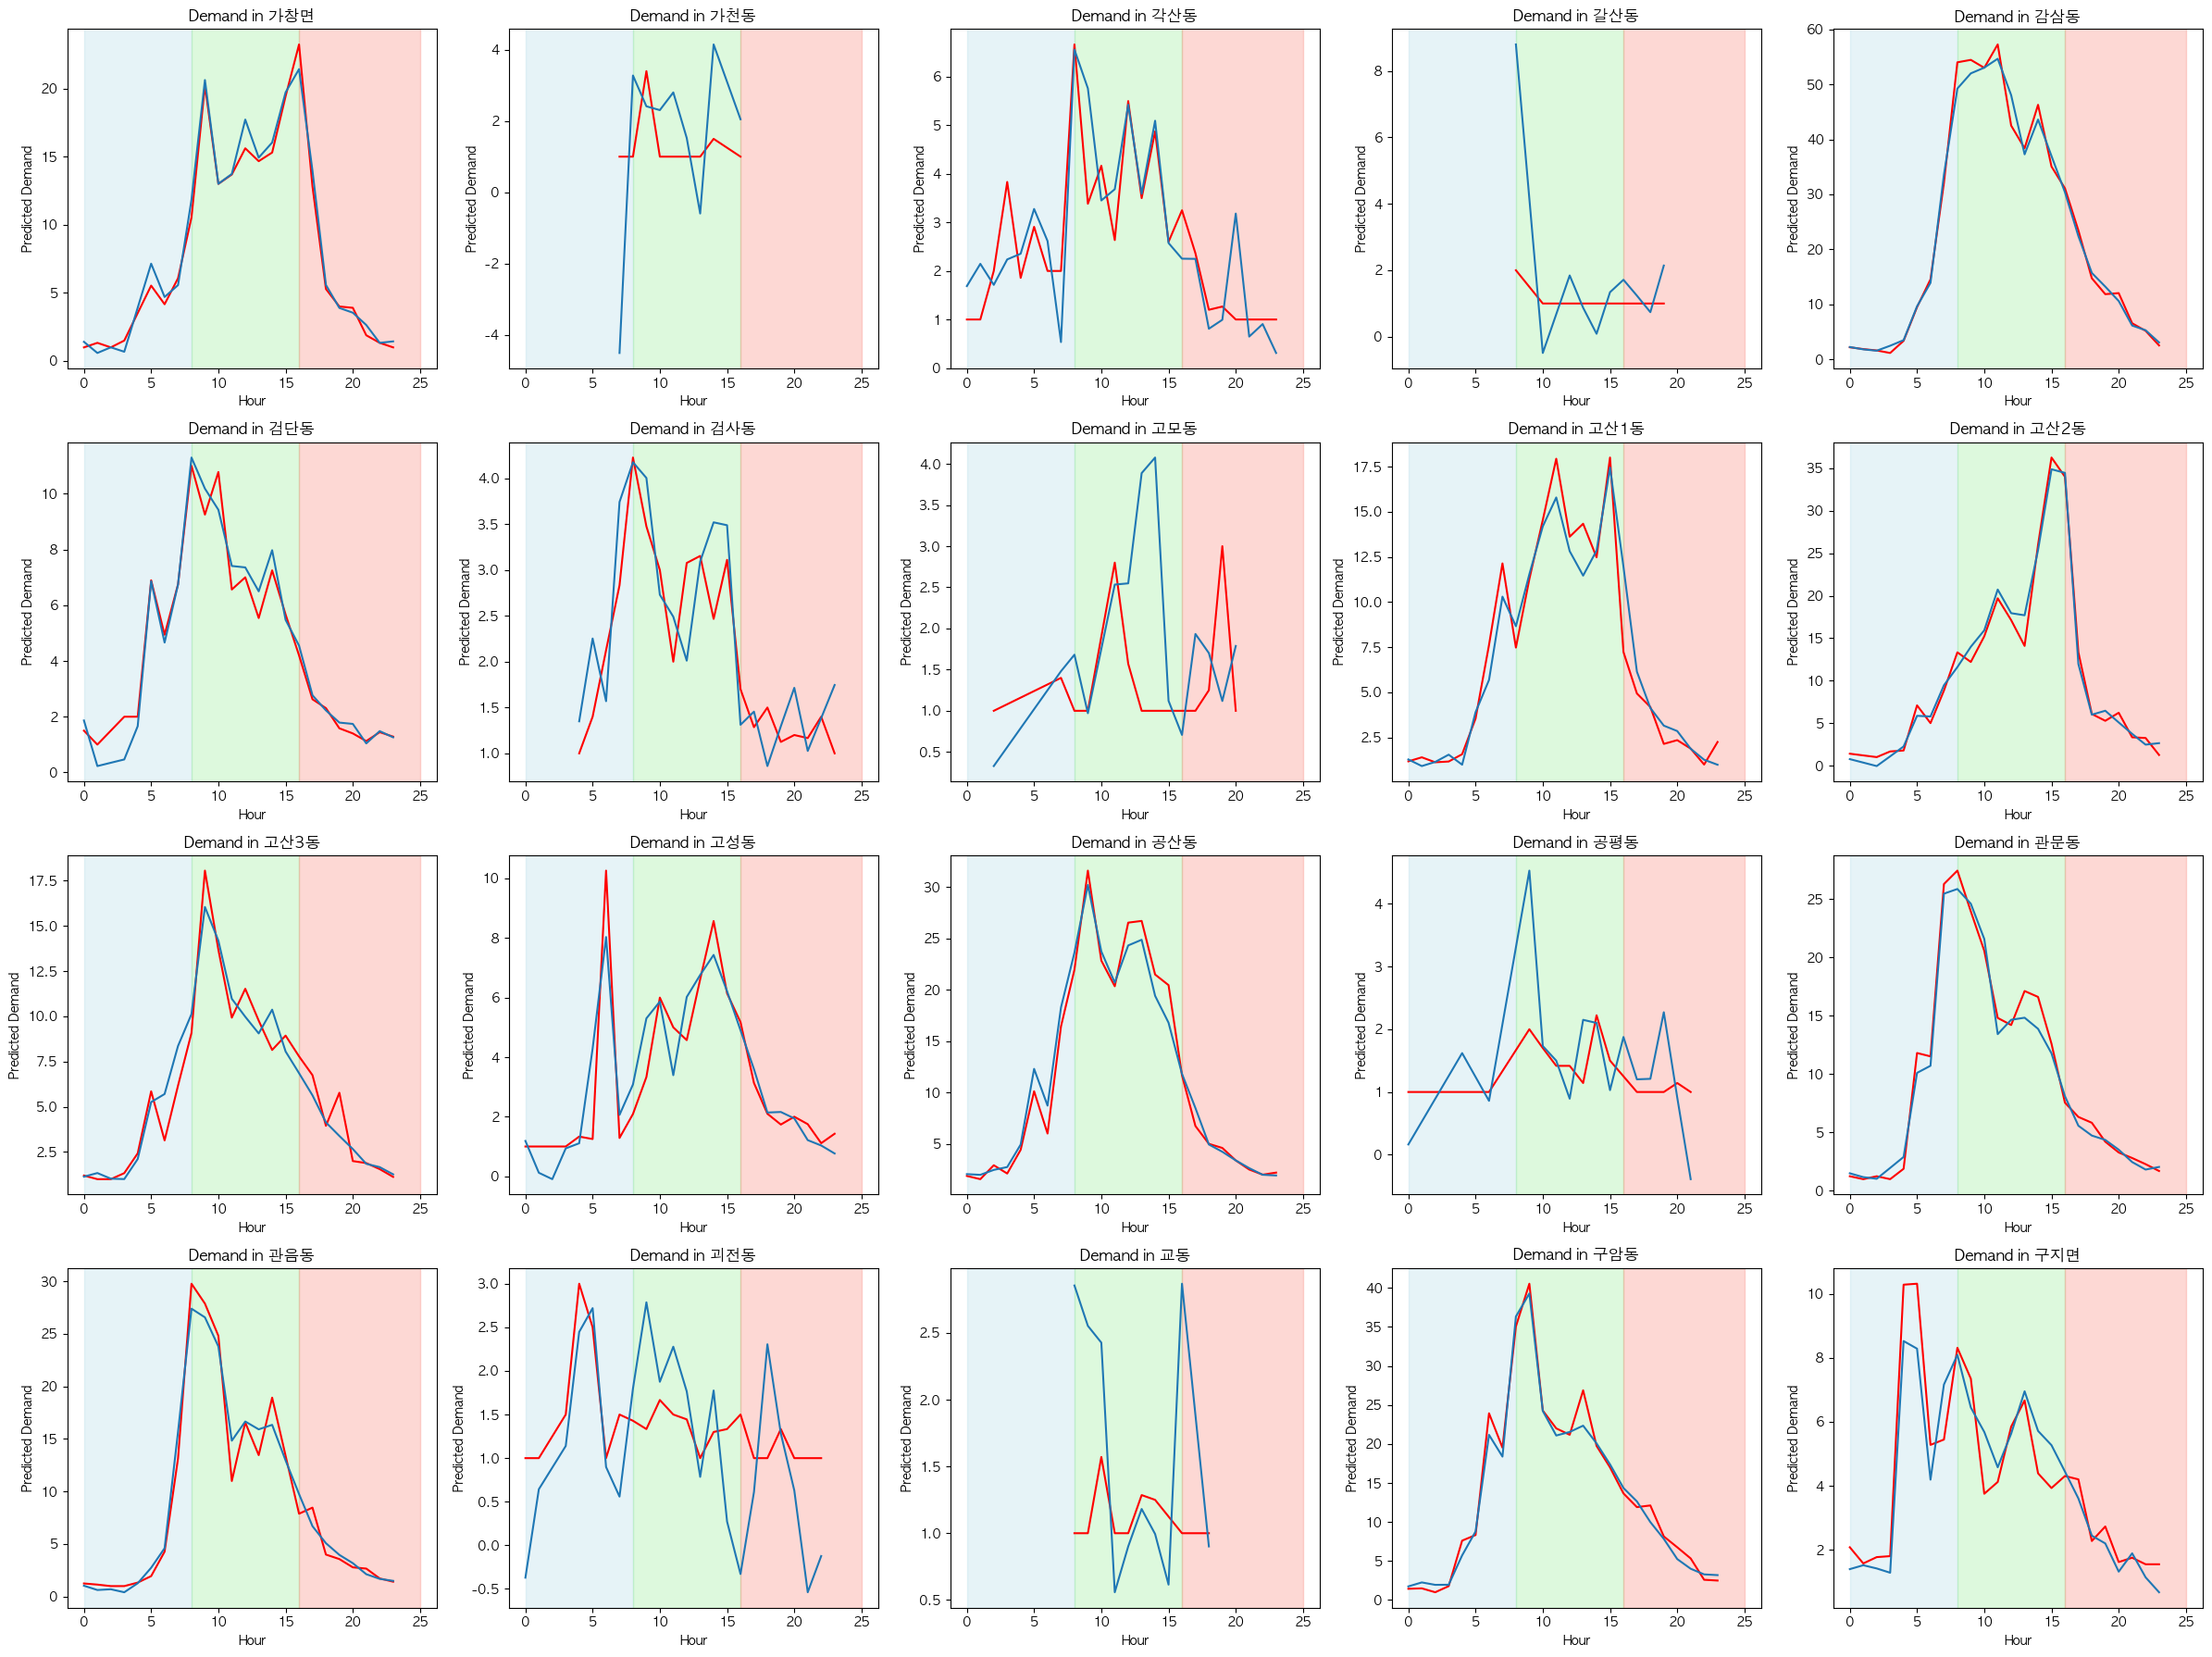

In [130]:
# 인덱스를 열로 리셋
hourly_demand_grouped = hourly_demand_grouped.reset_index()
hourly_demand_grouped['행정동']= le.inverse_transform(hourly_demand_grouped['행정동'])

# 시각화
plt.figure(figsize=(24, 18))

unique_districts = hourly_demand_grouped['행정동'].unique()

for i, district in enumerate(unique_districts):
    plt.subplot(4, 5, i+1)

    # Adding background color for different times of the day
    plt.axvspan(0, 8, color='lightblue', alpha=0.3)  # Early morning
    plt.axvspan(8, 16, color='lightgreen', alpha=0.3)  # Daytime
    plt.axvspan(16, 25, color='salmon', alpha=0.3)  # Evening

    district_data = hourly_demand_grouped[hourly_demand_grouped['행정동'] == district]
    sns.lineplot(data=district_data, x='시간', y='Actual', color='red')
    sns.lineplot(data=district_data, x='시간', y='Predicted')

    plt.title(f'Demand in {district}')
    plt.xlabel('Hour')
    plt.ylabel('Predicted Demand')

    if i >= 19:
        break

plt.tight_layout()
plt.show()